In [53]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 
# Import Dependencies
%matplotlib inline

# Start Python Imports
import math, time, random, datetime

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn-whitegrid')

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Machine learning
import catboost
from sklearn.model_selection import train_test_split
from sklearn import model_selection, tree, preprocessing, metrics, linear_model
from sklearn.svm import LinearSVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression, LogisticRegression, SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier, Pool, cv

# Let's be rebels and ignore warnings for now
import warnings
warnings.filterwarnings('ignore')

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.


/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv


**> Loading train and test data**********

In [54]:
train_data = pd.read_csv("/kaggle/input/titanic/train.csv")
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [55]:
train_data.describe(include="all")

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
count,891.000000,891.000000,891.000000,891,891,714.000000,891.000000,891.000000,891,891.000000,204,889
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,147,3
top,NaN,NaN,NaN,"Bishop, Mr. Dickinson H",male,NaN,NaN,NaN,CA. 2343,NaN,B96 B98,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,4,644
mean,446.000000,0.383838,2.308642,NaN,NaN,29.699118,0.523008,0.381594,NaN,32.204208,NaN,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,14.526497,1.102743,0.806057,NaN,49.693429,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,20.125000,0.000000,0.000000,NaN,7.910400,NaN,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,38.000000,1.000000,0.000000,NaN,31.000000,NaN,NaN


In [56]:
#check for any other unusable values
print(pd.isnull(train_data).sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [57]:
# Categorical features like Sex and Embarked need to be converted into Numerical features
df_train = pd.DataFrame()
embark_ohe = pd.get_dummies(train_data['Embarked'],prefix='embarked')
sex_ohe = pd.get_dummies(train_data['Sex'],prefix='sex')
pclass_ohe = pd.get_dummies(train_data['Pclass'],prefix='pclass')
df_train = pd.concat([embark_ohe,sex_ohe,pclass_ohe,train_data['Fare'],train_data['Parch'],train_data['SibSp'],train_data['Survived']],axis=1)
df_train

,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3,Fare,Parch,SibSp,Survived
0,0,0,1,0,1,0,0,1,7.2500,0,1,0
1,1,0,0,1,0,1,0,0,71.2833,0,1,1
2,0,0,1,1,0,0,0,1,7.9250,0,0,1
3,0,0,1,1,0,1,0,0,53.1000,0,1,1
4,0,0,1,0,1,0,0,1,8.0500,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,1,0,1,0,1,0,13.0000,0,0,0
887,0,0,1,1,0,1,0,0,30.0000,0,0,1
888,0,0,1,1,0,0,0,1,23.4500,2,1,0
889,1,0,0,0,1,1,0,0,30.0000,0,0,1


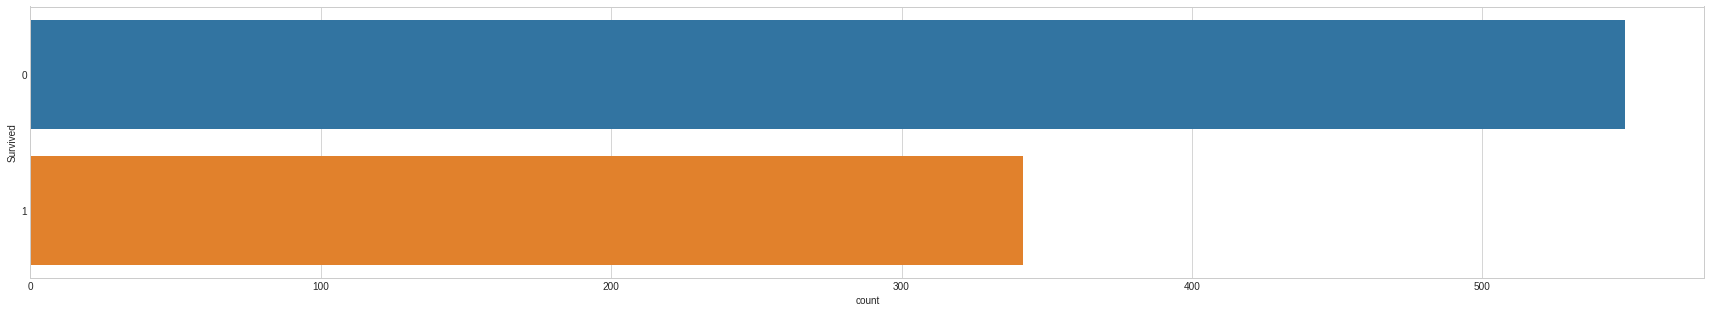

In [58]:
#Feature Contribution

# How many people survived?
fig = plt.figure(figsize=(30,5))
sns.countplot(y='Survived', data=df_train);

In [59]:
# Split the dataframe into data and labels
X_train = df_train.drop('Survived', axis=1) # data
y_train = df_train.Survived # labels
X_train.shape

(891, 11)

In [60]:
# Function that runs the requested algorithm and returns the accuracy metrics
def fit_ml_algo(algo, X_train, y_train, cv):
    
    # One Pass
    model = algo.fit(X_train, y_train)
    acc = round(model.score(X_train, y_train) * 100, 2)
    
    # Cross Validation 
    train_pred = model_selection.cross_val_predict(algo, 
                                                  X_train, 
                                                  y_train, 
                                                  cv=cv, 
                                                  n_jobs = -1)
    # Cross-validation accuracy metric
    acc_cv = round(metrics.accuracy_score(y_train, train_pred) * 100, 2)
    
    return train_pred, acc, acc_cv

Logistic Regression

In [31]:
# Logistic Regression
start_time = time.time()
train_pred_log, acc_log, acc_cv_log = fit_ml_algo(LogisticRegression(), 
                                                               X_train, 
                                                               y_train, 
                                                                    10)
log_time = (time.time() - start_time)
print("Accuracy: %s" % acc_log)
print("Accuracy CV 10-Fold: %s" % acc_cv_log)
print("Running Time: %s" % datetime.timedelta(seconds=log_time))

Accuracy: 80.02
Accuracy CV 10-Fold: 79.46
Running Time: 0:00:03.202649


K-NN

In [32]:
# k-Nearest Neighbours
start_time = time.time()
train_pred_knn, acc_knn, acc_cv_knn = fit_ml_algo(KNeighborsClassifier(), 
                                                  X_train, 
                                                  y_train, 
                                                  10)
knn_time = (time.time() - start_time)
print("Accuracy: %s" % acc_knn)
print("Accuracy CV 10-Fold: %s" % acc_cv_knn)
print("Running Time: %s" % datetime.timedelta(seconds=knn_time))

Accuracy: 83.61
Accuracy CV 10-Fold: 76.99
Running Time: 0:00:00.157099


Gaussian NB

In [33]:
# Gaussian Naive Bayes
start_time = time.time()
train_pred_gaussian, acc_gaussian, acc_cv_gaussian = fit_ml_algo(GaussianNB(), 
                                                                      X_train, 
                                                                      y_train, 
                                                                           10)
gaussian_time = (time.time() - start_time)
print("Accuracy: %s" % acc_gaussian)
print("Accuracy CV 10-Fold: %s" % acc_cv_gaussian)
print("Running Time: %s" % datetime.timedelta(seconds=gaussian_time))

Accuracy: 78.56
Accuracy CV 10-Fold: 78.11
Running Time: 0:00:00.128887


Linear SVC

In [34]:
# Linear SVC
start_time = time.time()
train_pred_svc, acc_linear_svc, acc_cv_linear_svc = fit_ml_algo(LinearSVC(),
                                                                X_train, 
                                                                y_train, 
                                                                10)
linear_svc_time = (time.time() - start_time)
print("Accuracy: %s" % acc_linear_svc)
print("Accuracy CV 10-Fold: %s" % acc_cv_linear_svc)
print("Running Time: %s" % datetime.timedelta(seconds=linear_svc_time))

Accuracy: 78.9
Accuracy CV 10-Fold: 76.21
Running Time: 0:00:00.352713


Decision Tree

In [35]:
# Decision Tree Classifier
start_time = time.time()
train_pred_dt, acc_dt, acc_cv_dt = fit_ml_algo(DecisionTreeClassifier(), 
                                                                X_train, 
                                                                y_train,
                                                                10)
dt_time = (time.time() - start_time)
print("Accuracy: %s" % acc_dt)
print("Accuracy CV 10-Fold: %s" % acc_cv_dt)
print("Running Time: %s" % datetime.timedelta(seconds=dt_time))

Accuracy: 92.48
Accuracy CV 10-Fold: 80.36
Running Time: 0:00:00.139760


In [61]:
test_data

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [62]:
# One hot encode the columns in the test data frame (like X_train)
test_embarked_one_hot = pd.get_dummies(test_data['Embarked'], 
                                       prefix='embarked')

test_sex_one_hot = pd.get_dummies(test_data['Sex'], 
                                prefix='sex')

test_plcass_one_hot = pd.get_dummies(test_data['Pclass'], 
                                   prefix='pclass')

# Combine the test one hot encoded columns with test
test_data = pd.concat([test_data, 
                  test_embarked_one_hot, 
                  test_sex_one_hot, 
                  test_plcass_one_hot], axis=1)
test_data['Fare'] = test_data['Fare'].fillna(0)


In [63]:
# Create a list of columns to be used for the predictions
wanted_test_columns = X_train.columns
test_data[wanted_test_columns]

,embarked_C,embarked_Q,embarked_S,sex_female,sex_male,pclass_1,pclass_2,pclass_3,Fare,Parch,SibSp
0,0,1,0,0,1,0,0,1,7.8292,0,0
1,0,0,1,1,0,0,0,1,7.0000,0,1
2,0,1,0,0,1,0,1,0,9.6875,0,0
3,0,0,1,0,1,0,0,1,8.6625,0,0
4,0,0,1,1,0,0,0,1,12.2875,1,1
...,...,...,...,...,...,...,...,...,...,...,...
413,0,0,1,0,1,0,0,1,8.0500,0,0
414,1,0,0,1,0,1,0,0,108.9000,0,0
415,0,0,1,0,1,0,0,1,7.2500,0,0
416,0,0,1,0,1,0,0,1,8.0500,0,0


In [66]:
# Make a prediction using the Decision Classifier model on the wanted columns
classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)
predictions = classifier.predict(test_data[wanted_test_columns])
predictions[:20]

array([0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1])

In [69]:
# Create a submisison dataframe and append the relevant columns
submission = pd.DataFrame()
submission['PassengerId'] = test_data['PassengerId']
submission['Survived'] = predictions # our model predictions on the test dataset
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


In [71]:
# Are our test and submission dataframes the same length?
if len(submission) == len(test_data):
    print("Submission dataframe is the same length as test ({} rows).".format(len(submission)))
else:
    print("Dataframes mismatched, won't be able to submit to Kaggle.")

Submission dataframe is the same length as test (418 rows).


In [72]:
# Convert submisison dataframe to csv for submission to csv 
# for Kaggle submisison
submission.to_csv('../DT_submission.csv', index=False)
print('Submission CSV is ready!')

Submission CSV is ready!


In [ ]:
# Check the submission csv to make sure it's in the right format
submissions_check = pd.read_csv("../DT_submission.csv")
submissions_check.head()